In [5]:
import numpy as np
import neuroboros as nb
from scipy.stats import zscore,pearsonr
from scipy.spatial.distance import pdist, cdist, squareform
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from hyperalignment.procrustes import procrustes
from hyperalignment.ridge import ridge
from hyperalignment.local_template import compute_template
from hyperalignment.searchlight import searchlight_procrustes, searchlight_ridge, searchlight_template
import pandas as pd
import seaborn as sns

## Load data
Data is preprocessed on the fly to regress out motion etc. in the get_data() function

In [2]:
dset = nb.Life()
sids = dset.subjects
print(sids)

['rid000001', 'rid000005', 'rid000006', 'rid000009', 'rid000012', 'rid000014', 'rid000017', 'rid000019', 'rid000020', 'rid000024', 'rid000027', 'rid000031', 'rid000032', 'rid000033', 'rid000034', 'rid000036', 'rid000037', 'rid000038', 'rid000041']


## Local template

In [3]:
sls = nb.sls('r', 20)
roi = sls[5876]
dms = []
for sid in sids:
    dm = dset.get_data(sid, 'life', [1, 2], 'r')
    dm = dm[:, roi]
    dms.append(dm)
dms = np.stack(dms, axis=0)

In [4]:
ns, nt, nv = dms.shape
print(dms.shape)

(19, 704, 122)


In [6]:
local_template = compute_template(dms, kind='pca', max_npc=nv, common_topography=False)
print(local_template.shape)

(704, 122)


## Wholebrain template

In [9]:
# For conveience, we just illustrate with the right hemisphere
radius = 10
lr = 'r'
sls, dists = nb.sls(lr, radius, return_dists=True)

In [10]:
dms = []
for sid in sids:
    dm = dset.get_data(sid, 'life', [1, 2], lr)
    dms.append(dm)
dms = np.stack(dms, axis=0)

In [11]:
print(dms.shape)

(19, 704, 9666)


In [12]:
wholebrain_template = searchlight_template(dms, sls, dists, radius, n_jobs=5, tmpl_kind="pca")

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


In [13]:
wholebrain_template.shape

(704, 9666)

## Check Representational Dissimilarity Matrix

In [14]:
rdms = []
for dm in dms:
    rdm = pdist(dm, 'euclidean')
    rdms.append(rdm)
rdms = np.array(rdms)

In [19]:
print(rdms.shape)

(19, 247456)


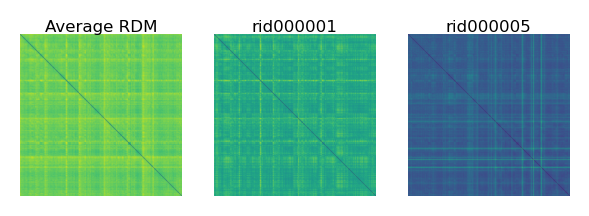

In [15]:
fig, axs = plt.subplots(1, 3, figsize=[_/2.54 for _ in [9, 3]], dpi=200)
mats = [squareform(_) for _ in [rdms.mean(axis=0), rdms[0], rdms[1]]]
for i, (mat, ax) in enumerate(zip(mats, axs)):
    ax.set_title(['Average RDM', sids[0], sids[1]][i], size=6, pad=1)
    ax.imshow(mat, vmin=0)
    ax.axis('off')
plt.show()

In [18]:
template_rdm = pdist(wholebrain_template, 'euclidean')
print(template_rdm.shape)

(247456,)


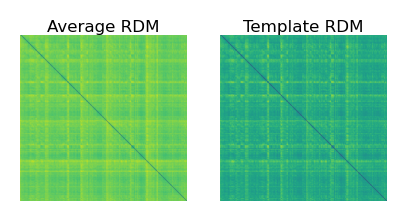

In [21]:
fig, axs = plt.subplots(1, 2, figsize=[_/2.54 for _ in [6, 3]], dpi=200)
mats = [squareform(_) for _ in [rdms.mean(axis=0), template_rdm]]
for i, (mat, ax) in enumerate(zip(mats, axs)):
    ax.set_title(['Average RDM', 'Template RDM'][i], size=6, pad=1)
    ax.imshow(mat, vmin=0)
    ax.axis('off')
plt.show()

In [22]:
dm = dms[0]
print((dm**2).sum())
print(((dm - wholebrain_template)**2).sum())

6804864.0
7276121.405353919


In [23]:
R = procrustes(wholebrain_template, dm)
print(R.shape)
print(((dm - wholebrain_template @ R)**2).sum())

(9666, 9666)
2807978.0366876163
